### Set up

In [1]:
#Import modules

import pandas as pd
pd.options.display.max_columns = 99
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import dask.dataframe as dd
from dask.diagnostics import ProgressBar

# from numpy import arange, log10

from functions import chunk, agg, finalize
tunique = dd.Aggregation('tunique', chunk, agg,finalize)
first = dd.Aggregation('first', chunk, agg,finalize)

## Sourcing info
### Arrange data

In [3]:
pd.read_csv('./../../../../../../media/miglesia/Elements/export_france/data/type1/DP1610_MAASTRICHT1_1997_2013/DP1610_MAASTRICHT1_1997.txt', 
                delimiter = ';', header = None, dtype = {9: 'object'})

MemoryError: 

In [5]:
drive_path = './../../../../../../media/miglesia/Elements/export_france/data/type1/DP1610_MAASTRICHT1_1997_2013'

colnames = [u'YEAR', u'MONTH', u'FLUX', u'ID', u'DEPT', u'CN ID 8', u'CPA6',
       u'PYOD', u'PAYP', u'VAT', u'PRIFAC', u'DEVFAC', u'VFTE', u'VART', u'D_MASSE', u'MASSE', u'USUP', u'USUP_MT']

colname_no = dict(zip(colnames, range(18)))
# columns = [u'YEAR', u'MONTH', u'FLUX', u'ID', u'VART']
columns = [u'YEAR', u'MONTH', u'FLUX', u'ID', u'CN ID 8', 'PYOD', u'VART']

df_list = []

for y in range(1997, 2000):
    filename = drive_path+'/DP1610_MAASTRICHT1_'+str(y)+'.txt'
    df_list += [dd.read_table(filename, 
                usecols = map(colname_no.get, columns),
                delimiter = ';', header = None, dtype = {9: 'object'})]

data = dd.concat(df_list)
data.columns = columns
data['IMPORT'] = data['FLUX'] % 2
data['QUARTER'] = ((data['MONTH'] -1)// 3) + 1

CN_full = pd.read_csv('./../data/CN_full.csv', encoding = 'utf-8')
data = data.merge(CN_full[['CN ID 8', 'CN ID 4', 'CN label 4']])#.persist()

sourcing_strategies = data.loc[data.IMPORT == 1].groupby(['YEAR', 'ID', 'CN ID 4', 'PYOD'])[['VART']].sum() #rm QUARTER for yearly dataset
export_bundles = data.loc[data.IMPORT == 0].groupby(['YEAR', 'ID', 'CN ID 4', 'PYOD'])[['VART']].sum()

## Compute and save

with ProgressBar():
    out = sourcing_strategies.compute()
out.to_csv('./../../../../../../media/miglesia/Elements/export_france/data/processed/sourcing_strategies_yr.csv')

with ProgressBar():
    out2 = export_bundles.compute()
out2.to_csv('./../../../../../../media/miglesia/Elements/export_france/data/processed/export_bundles_yr.csv')

[########################################] | 100% Completed |  1min 26.6s
[########################################] | 100% Completed |  1min 32.4s


### Load data directly

In [ ]:
out = pd.read_csv('./../data/sourcing_strategies.csv')
# out = pd.read_csv('./../data/export_bundles.csv')
out_ri = out.reset_index()
# product_count = out_ri.groupby('ID')[['CN ID 4']].nunique()
sources_count = out_ri.groupby('ID')[['PYOD']].nunique()
multisourcing_firms = sources_count[sources_count['PYOD'] > 1].index
df = out_ri.loc[out_ri.ID.isin(multisourcing_firms)]

In [ ]:
firm_prod = df.groupby(['ID', 'CN ID 4']).sum()['VART'].reset_index()

firm_prod_pcts = firm_prod.groupby('ID')['VART'].apply(lambda x:
                                                 100 * x / float(x.sum()))
firm_prod['pct'] = firm_prod_pcts

### Show some examples of firm sourcing strategies in time

In [4]:
# df_.set_index('ID').loc[sample_ids]

In [ ]:

sample_ids = df.sample(10)['ID'].values

#Select firms that import more than 10% of some product
# df_ = firm_prod.loc[(firm_prod['CN ID 4'] == 601) & (firm_prod['pct'] > 1)]
# sample_ids = df_.sample(10)['ID'].values

for id_ in sample_ids:
    df_ID = df.loc[df.ID == id_]
    
    by_product = df_ID.groupby('CN ID 4')['VART'].sum().sort_values(ascending = False)
    by_product/=by_product.sum()
    main_prods = by_product[by_product.cumsum() < .99].index
    df_ID_mp = df_ID.loc[df_ID['CN ID 4'].isin(main_prods)]
    
    table = df_ID_mp.set_index([u'CN ID 4', u'PYOD', u'QUARTER', u'YEAR'])['VART'].unstack([-1, -2]).fillna(0)
    table[('min','')] = 0; table[('max','')] = table.max().max()

    display(CN_full.set_index('CN ID 4')[['CN label 4']].drop_duplicates().loc[df_ID_mp['CN ID 4'].unique()].sort_index())

    display(table.T.style.bar(color='#d65f5f'))

/home/miglesia/anaconda2/lib/python2.7/site-packages/IPython/kernel/__main__.py:4: RuntimeWarning: divide by zero encountered in log10


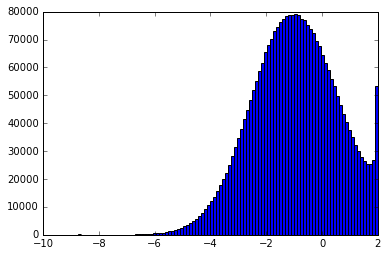

In [22]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.hist(np.log10(firm_prod['pct']).replace(-np.inf, np.nan).dropna().values, 100)
plt.show()